In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import case_config
from copy import copy

/home/chris/miniconda3/envs/rlearn/lib/python3.6/site-packages/matplotlib/style/core.py:167: UserWarning: In /home/chris/.config/matplotlib/stylelib/lm.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  styles = read_style_directory(stylelib_path)
/home/chris/miniconda3/envs/rlearn/lib/python3.6/site-packages/matplotlib/style/core.py:167: UserWarning: In /home/chris/.config/matplotlib/stylelib/mystyle-lm.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  styles = read_style_directory(stylelib_path)
/home/chris/miniconda3/envs/rlearn/lib/python3.6/site-packages/matplotlib/style/core.py:167: UserWarning: In /home/chris/.config/matplotlib/stylelib/mystyle-lm-small.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  styles = read_style_directory(stylelib_path)


In [2]:
plt.style.use("./rlearn.mplstyle")

/home/chris/miniconda3/envs/rlearn/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
plt.rcParams['font.size']

14.0

- 47 rates
- 14 different #realizations
- 10 runs each

In [4]:
case_config.print_config(False)

ReaDDy learn config
*********************************************
Target time: 2.0
Gillespie intermediate rescaling factor: 500.0
Discretization timestep: 0.003


In [5]:
#DATA_ROOT = "/home/mho/Dropbox/phd/readdy_learn/reaction_learn_data"
DATA_ROOT = "/home/chris/Dropbox/readdy_learn/reaction_learn_data"
crop_estimated_rates = True
gillespie_realizations = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]

### Transform realizations to noise-level

47
47
n_frames=667, n_species=9


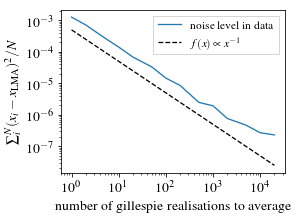

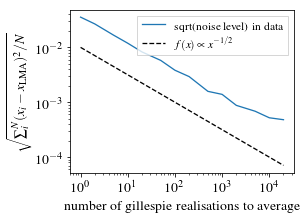

In [7]:
noisy_species = np.array([2,1,5,4,8,7])
def get_lma_counts(init=1):
    regulation_network, analysis = case_config.get_regulation_network_lma(init=init)
    traj = analysis.get_traj(0)
    return traj.counts, traj.dcounts_dt, traj.time_step

# get noisefree solution
lma_counts, _, _ = get_lma_counts(init=1)
lma_counts = lma_counts[:, noisy_species]
#plt.plot(lma_counts)

# calculate mean squared deviation
n_gill = 1
iid = 0
noise_level = np.zeros(len(gillespie_realizations))
for i_gill, number_gill in enumerate(gillespie_realizations):
    mses = []
    for iid in range(10):
        counts, _ = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_init_1.h5"), number_gill, iid)
        counts = counts[:, noisy_species]
        n_samples = counts.size
        mse = np.sum(np.power(counts - lma_counts, 2)) / n_samples
        mses.append(mse)
    mses = np.array(mses)
    noise_level[i_gill] = np.mean(mses)

gill_arr = np.array(gillespie_realizations, dtype=float)
# gillespie realizations -> noise level relation
plt.plot(gillespie_realizations, noise_level, label="noise level in data")
plt.plot(gill_arr, 0.5e-3*np.power(gill_arr, -1), "k--", label="$f(x)\propto x^{-1}$")
plt.xlabel("number of gillespie realisations to average")
plt.ylabel(r"$\sum^N_i (x_i -x_\mathrm{LMA})^2/N$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()
plt.plot(gillespie_realizations, np.sqrt(noise_level), label="sqrt(noise level) in data")
plt.plot(gill_arr, 1e-2*np.power(gill_arr, -1./2.), "k--", label="$f(x)\propto x^{-1/2}$")
plt.xlabel("number of gillespie realisations to average")
plt.ylabel(r"$\sqrt{\sum^N_i (x_i -x_\mathrm{LMA})^2/N}$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

### Convergence

In [8]:
with open(os.path.join(DATA_ROOT, 'case2_validation_alphas_and_solutions_averagefolds_shuffled.npz'), 'rb') as f:
    X = np.load(f)
    rates = X['rates']
    l1_dev = X['l1_dev']
    alpha_val = X['alpha_val']

In [9]:
with open(os.path.join(DATA_ROOT, 'case2_solutions_lsq_zippedtraj_shuffled.npz'), 'rb') as f:
    X = np.load(f)
    lsq_rates = X['rates']
    lsq_l1_dev = X['l1_dev']
    lsq_alpha_val = X['alpha_val']
    assert all(gillespie_realizations == X['gillespie_realisations'])

In [10]:
if crop_estimated_rates:
    for gillespie_realization in range(len(gillespie_realizations)):
        estimated_rates = rates[gillespie_realization]
        cropped_rates = estimated_rates[:]
        cropped_rates[cropped_rates < case_config.CASE1_CUTOFF] = 0.
        for arr in np.bitwise_or(cropped_rates >= case_config.CASE1_CUTOFF, cropped_rates == 0):
            assert all(arr)
        for i in range(l1_dev.shape[1]):
            l1_dev[gillespie_realization][i] = np.sum(np.abs(cropped_rates[i] - case_config.DESIRED_RATES))
    for gillespie_realization in range(len(gillespie_realizations)):
        estimated_rates = lsq_rates[gillespie_realization]
        cropped_rates = estimated_rates[:]
        cropped_rates[cropped_rates < case_config.CASE1_CUTOFF] = 0.
        for arr in np.bitwise_or(cropped_rates >= case_config.CASE1_CUTOFF, cropped_rates == 0):
            assert all(arr)
        for i in range(lsq_l1_dev.shape[1]):
            lsq_l1_dev[gillespie_realization][i] = np.sum(np.abs(cropped_rates[i] - case_config.DESIRED_RATES))

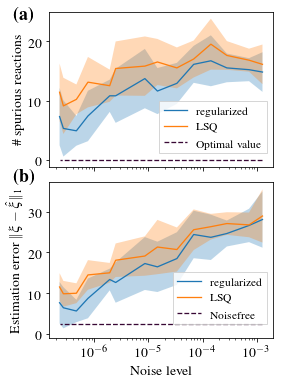

In [11]:
fs = copy(plt.rcParams.get('figure.figsize'))
fs[1] = 2*fs[1]
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=fs, sharex=True)


x_data = noise_level
#x_data = gillespie_realizations

failure_rates = []
failure_rates_lsq = []
failure_rates_std = []
failure_rates_lsq_std = []
for gillespie_realization in range(len(gillespie_realizations)):
    estimated_rates = rates[gillespie_realization]
    r = [case_config.failure_rate(x) for x in estimated_rates]
    failure_rates.append(np.mean(r))
    failure_rates_std.append(np.std(r))
    
    r = [case_config.failure_rate(x) for x in lsq_rates[gillespie_realization]]
    failure_rates_lsq.append(np.mean(r))
    failure_rates_lsq_std.append(np.std(r))

failure_rates = np.array(failure_rates)
failure_rates_std = np.array(failure_rates_std)
ax1.plot(x_data, failure_rates, label='regularized')
ax1.fill_between(x_data, y1=failure_rates-failure_rates_std, y2=failure_rates+failure_rates_std, alpha=0.3)
ax1.plot(x_data, failure_rates_lsq, label='LSQ')
ax1.fill_between(x_data, y1=failure_rates_lsq-failure_rates_std, y2=failure_rates_lsq+failure_rates_std, alpha=.3)
ax1.plot(x_data, [0]*len(x_data), '--', color='xkcd:eggplant', label='Optimal value')
ax1.set_xscale('log')
# ax1.set_xlabel('Number of measurements')
ax1.set_ylabel('\# spurious reactions')
ax1.legend(loc='lower right', bbox_to_anchor=(1, 0.05))

mean = np.mean(l1_dev, axis=1)
err = np.std(l1_dev, axis=1) #/ np.sqrt(10.) # 10 iids
mean_lsq = np.mean(lsq_l1_dev, axis=1)
err_lsq = np.std(lsq_l1_dev, axis=1)
ax2.plot(x_data, mean, label=r'regularized')
ax2.fill_between(x_data, y1=np.clip(mean-err, 0., 1e16), y2=mean+err, alpha=0.3)
ax2.plot(x_data, mean_lsq, label=r'LSQ')
ax2.fill_between(x_data, y1=mean_lsq-err_lsq, y2=mean_lsq+err_lsq, alpha=.3)
ax2.set_xscale("log")
ax2.set_xlabel("Noise level")
ax2.set_ylabel(r"Estimation error $\|\xi-\hat{\xi}\|_1$")
# plt.title("Deviation of estimated rates from desired rates")
ymin, ymax = plt.ylim()
ax2.set_ylim(-1,ymax)
ax2.plot(x_data, [case_config.CASE1_MIN_L1_ERR]*len(x_data), 
         '--', color='xkcd:eggplant', label='Noisefree')
ax2.legend(loc='lower right', bbox_to_anchor=(1, 0.05))

f.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

f.text(-0., .86, r'\textbf{(a)}', fontdict={'size': plt.rcParams['font.size']+4})
f.text(-0., .485, r'\textbf{(b)}', fontdict={'size': plt.rcParams['font.size']+4})


f.savefig("case2.pdf", bbox_inches="tight", transparent=True)